# Neural Style Transfer Learning

## Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import time

from tensorflow.keras import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tqdm import tqdm
from IPython.display import Image as IPImage
from PIL.Image import fromarray

## Define Content Image and Style Image Paths

In [2]:
c_path = './images/content_image.jpg'
s_path = './images/style_image.jpg'

## Display Content Image

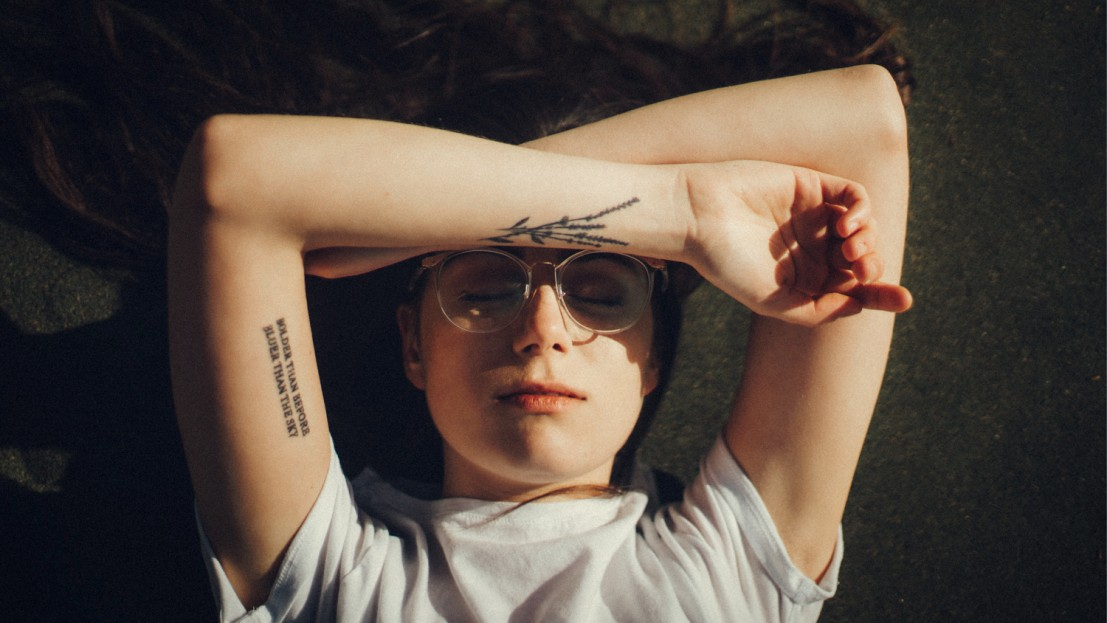

In [3]:
content_image = IPImage(c_path)
display(content_image)

## Display Style Image

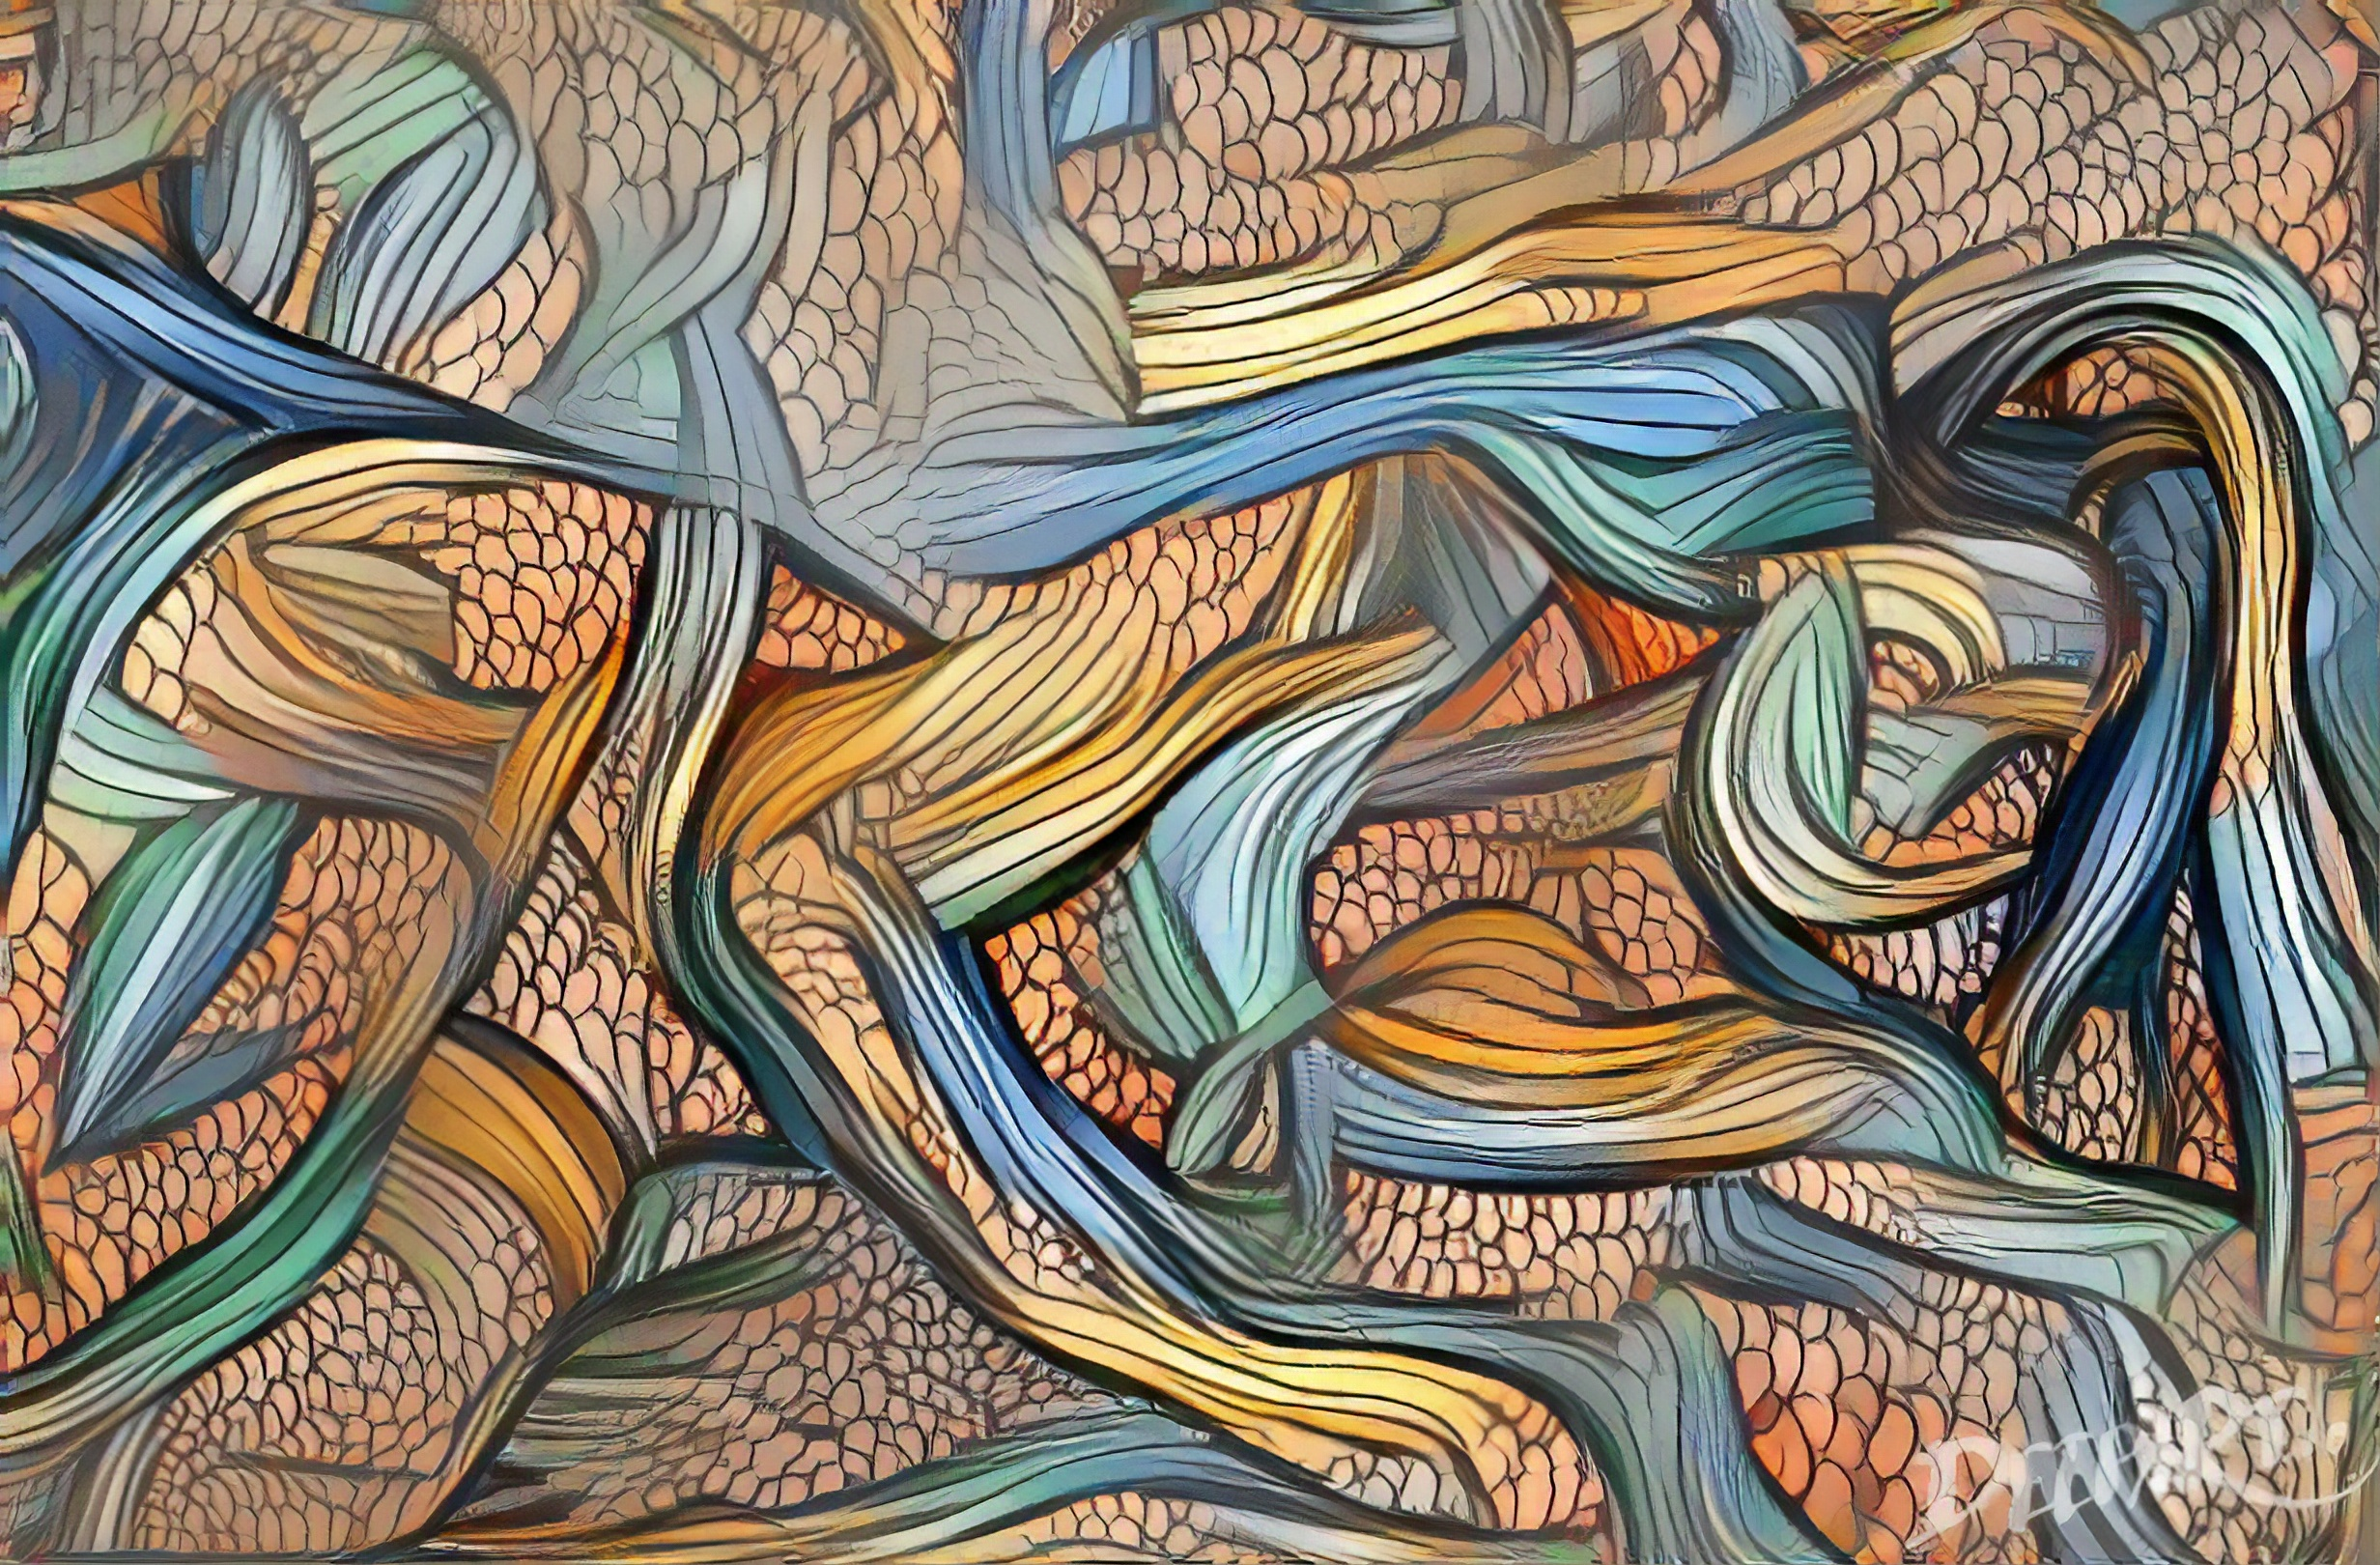

In [4]:
style_image = IPImage(s_path)
display(style_image)

## Define Functions That Convert Images <-> Tensors

In [5]:
def image_to_tensor(path_to_img):
    max_dim = 1024
    image_tensor = tf.io.read_file(path_to_img)
    image_tensor = tf.image.decode_image(image_tensor, channels = 3)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)

    shape = tf.cast(tf.shape(image_tensor)[:-1], tf.float32)
    scale = max_dim / max(shape)
    
    new_shape = tf.cast(shape * scale, tf.int32)
    image_tensor = tf.image.resize(image_tensor, new_shape)
    image_tensor = image_tensor[tf.newaxis, :]
    
    return image_tensor

c_image = image_to_tensor(c_path) #c = content
s_image = image_to_tensor(s_path) #s = style
    
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype = np.uint8)
    
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    return fromarray(tensor)

## Define NST Model That Extracts Outputs From The Intermediate Layers (VGG19)

In [6]:
c_layers = ['block5_conv2'] 
s_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_c_layers = len(c_layers)
num_s_layers = len(s_layers)

def vgg_layers(layer_names):
    vgg = VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    
    return model

def gram_matrix(tensor):
    shape_tensor = tf.shape(tensor)
    num_of_terms = tf.cast(shape_tensor[1] * shape_tensor[2], tf.float32)
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    
    return result / num_of_terms

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, s_layers, c_layers):
        super(StyleContentModel, self).__init__()
        
        self.vgg = vgg_layers(s_layers + c_layers)
        
        self.s_layers = s_layers
        self.c_layers = c_layers
        
        self.num_s_layers  = len(s_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        "Expects float input in [0,1]"
        outputs = self.vgg(preprocess_input(inputs * 255))
        
        s_outputs, c_outputs = (
            outputs[:self.num_s_layers], 
            outputs[self.num_s_layers:]
        )

        s_outputs = [gram_matrix(s_output) for s_output in s_outputs]

        c_dict = {c_name:value for c_name, value in zip(self.c_layers, c_outputs)}
        s_dict = {s_name:value for s_name, value in zip(self.s_layers, s_outputs)}
    
        return {'c':c_dict, 's':s_dict}

extractor = StyleContentModel(s_layers, c_layers)
s_targets = extractor(s_image)['s']
c_targets = extractor(c_image)['c']

## Define Style and Content Loss

In [7]:
s_weight  = 100
c_weight  = 1
tv_weight = 20 # tv = total_variation

def style_content_loss(outputs):
    s_outputs = outputs['s']
    c_outputs = outputs['c']
    
    s_loss = tf.add_n(
        [
            tf.reduce_mean((s_outputs[name] - s_targets[name]) ** 2) 
            for name in s_outputs.keys()
        ]
    )
    
    s_loss *= s_weight / num_s_layers

    c_loss = tf.add_n(
        [
            tf.reduce_mean((c_outputs[name] - c_targets[name]) ** 2) 
            for name in c_outputs.keys()
        ]
    )
    
    c_loss *= c_weight / num_c_layers
    
    return s_loss + c_loss


## Define Training Step

In [8]:
image_tensor = tf.Variable(c_image)
parameters = {'learning_rate': 0.02, 'beta_1': 0.99, 'epsilon': 1e-1} 
optimizer  = tf.optimizers.Adam(**parameters)

def clip_0_1(image_tensor):
    return tf.clip_by_value(image_tensor, 0.0, 1.0)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image_tensor)
        loss  = style_content_loss(outputs)
        loss += tv_weight * tf.image.total_variation(image_tensor) # To smoothen image

    gradients = tape.gradient(loss, image_tensor)
    optimizer.apply_gradients([(gradients, image_tensor)])
    image_tensor.assign(clip_0_1(image_tensor))

## Train And Display New Image

100%|██████████| 40/40 [16:37<00:00, 24.95s/it]


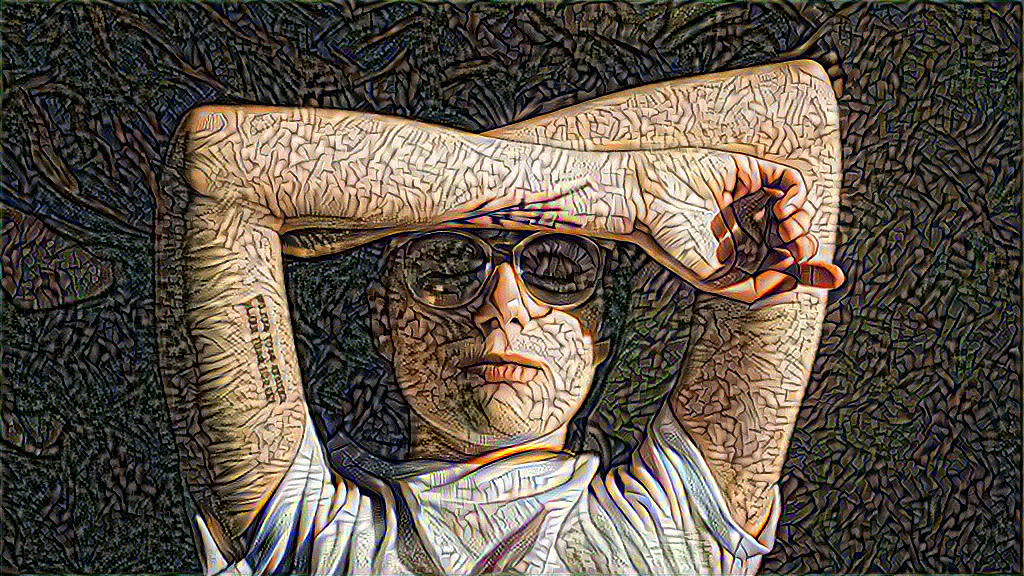

In [9]:
for _ in tqdm(range(40)):
    train_step(image_tensor)

tensor_to_image(image_tensor)